## Advanced Lane Finding

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [1]:
# Import Statements
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML        

In [2]:
# common functions
def displayImagesForComparison(leftImg, rightImg, leftTitle, rightTitle, show_axis='off', is_gray=False):
    fig, (col1, col2) = plt.subplots(1, 2, figsize=(20,10))
    if is_gray == True:
        col1.imshow(leftImg, cmap='gray')
    else:
        col1.imshow(leftImg)
    col1.axis(show_axis)
    col1.set_title(leftTitle, fontsize=20)
    if is_gray == True:
        col2.imshow(rightImg, cmap='gray')
    else:
        col2.imshow(rightImg)
    col2.set_title(rightTitle, fontsize=20)
    col2.axis(show_axis)

### Compute the camera calibration matrix and distortion coefficients given a set of chessboard images

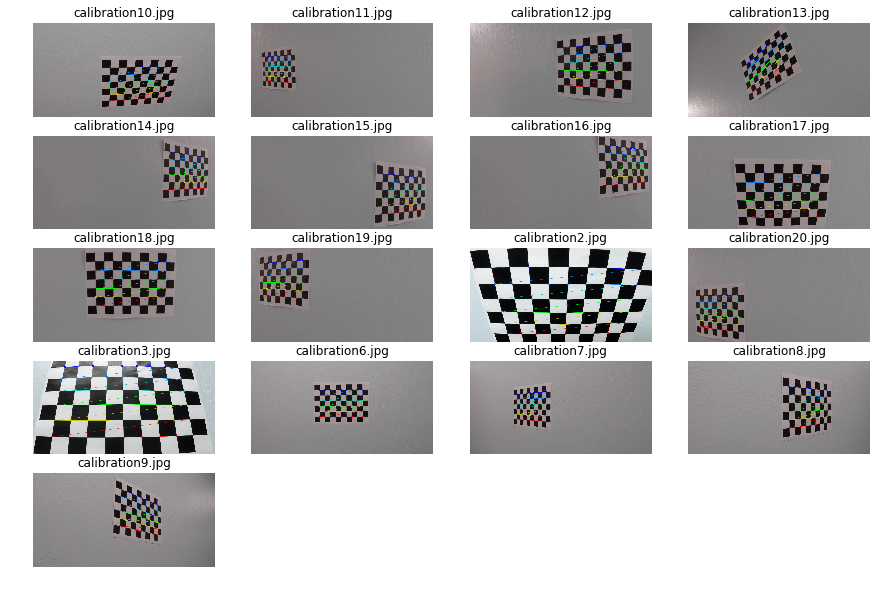

In [3]:
# Chessboard Corners
nx = 9
ny = 6

objp = np.zeros((nx*ny,3), np.float32)
# x and y cordinates.
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
objpoints = []
imgpoints = []

# Make a list of calibration images
images = glob.glob('./camera_cal/cali*.jpg')
count = 0
fig, axes = plt.subplots(5, 4, figsize=(15,10), sharex=True)

lastidx = len(images) - 1

# itreate over all images and draw corners and save files
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    #print('Image Name: {}, Rect: {}'.format(fname, ret))
    
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img_cor = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        ax = axes.flat[count]
        ax.axis('off')
        ax.imshow(img_cor)
        fname = fname.split('\\calibration')[-1]
        ax.set_title('calibration' + fname)
        
        write_name = './cornered_images/calibrated'+ fname +'.jpg'
        cv2.imwrite(write_name, img)
        count += 1
    else:
        #remove the last index as there are no sufficient images to display
        fig.delaxes(axes.flat[lastidx])
        lastidx -=1

The camera is calibrated! Information is saved.


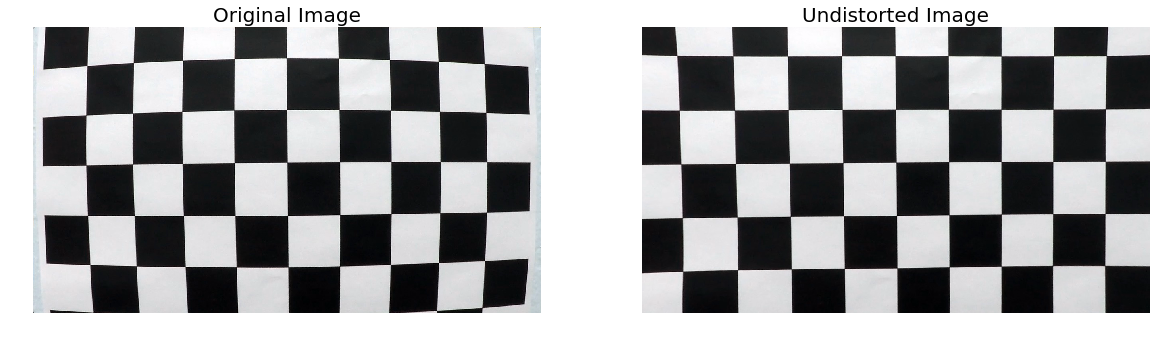

In [4]:
# Test undistortion on an image
orig = cv2.imread('./camera_cal/calibration1.jpg')
orig_shapee = (orig.shape[1], orig.shape[0])

# Calibrate camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, orig_shapee,None,None)

undist = cv2.undistort(orig, mtx, dist, None, mtx)
cv2.imwrite('./output_images/calibration1_undist.jpg',undist)

# Save the camera calibration result for later use
pickle.dump( { 'mtx': mtx, 'dist': dist }, open( "./output_images/camera_calibration.p", "wb" ) )

displayImagesForComparison(orig, undist, 'Original Image', 'Undistorted Image')
print("The camera is calibrated! Information is saved.")

# Distortion Correction

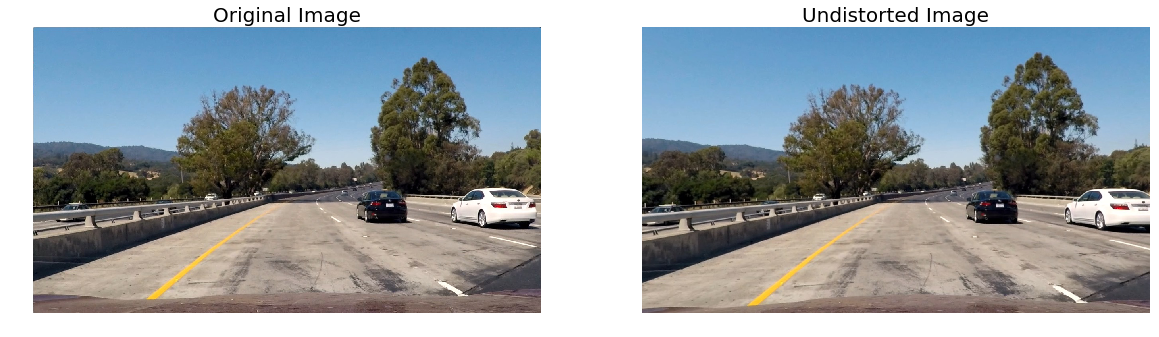

In [5]:
import matplotlib.image as mpimg
from skimage import img_as_ubyte
%matplotlib inline

# load camera calibration
with open('./output_images/camera_calibration.p', "rb") as pf:
        calibration = pickle.load(pf)
        mtx, dist = map(calibration.get, ('mtx', 'dist'))

# assert calibration load status
assert mtx is not None
assert mtx.shape == (3,3)
assert dist is not None

def apply_undistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

img = cv2.imread('./test_images/test1.jpg')
img_undist = apply_undistort(img, mtx, dist)

# to display rgb colors
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_undist = cv2.cvtColor(img_undist, cv2.COLOR_BGR2RGB)

displayImagesForComparison(img, img_undist, 'Original Image','Undistorted Image')

### Use color transforms, gradients, etc., to create a thresholded binary image

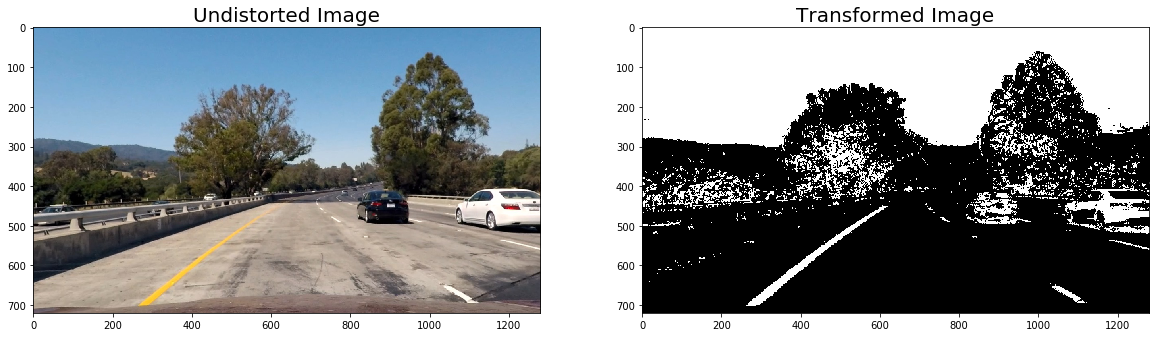

In [6]:
# Apply gradiant
def getAbsSoble(img, kernal):
    img = np.copy(img)

    # Convert to HSV color space and extract S channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hsv[:,:,2]

    # Sobel x and y
    x_sobel = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0, ksize=kernal)
    y_sobel = cv2.Sobel(s_channel, cv2.CV_64F, 0, 1, ksize=kernal)

    # calculate absolute
    x_abs = np.absolute(x_sobel)
    y_abs  = np.absolute(y_sobel)
    
    return s_channel, x_abs, y_abs

# Apply threshold, color transform, etc
def getTransformedImage(img, sobel_kernel=3, sc_thresh=(110, 255), sx_thresh=(20, 100)):
    s_channel, abs_x_sobel, abs_y_sobel = getAbsSoble(img, sobel_kernel)

    # Convert to uint8
    scaled_sobel_x = np.uint8(255.0*abs_x_sobel/np.max(abs_x_sobel))

    # Apply x gradient threshold
    sx_binary = np.zeros_like(scaled_sobel_x)
    sx_binary[(scaled_sobel_x >= sx_thresh[0]) & (scaled_sobel_x <= sx_thresh[1])] = 1
    
    # Apply color channel threshold
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= sc_thresh[0]) & (s_channel <= sc_thresh[1])] = 1

    # combine gradients.
    output_binary = np.zeros_like(sx_binary)
    output_binary[(sx_binary == 1) | (s_binary == 1)] = 1

    return output_binary

img_binary = getTransformedImage(img_undist)
fig, (col1, col2) = plt.subplots(1, 2, figsize=(20,10))
col1.imshow(img_undist)
col1.set_title('Undistorted Image', fontsize=20)
col2.imshow(img_binary, cmap='gray')
col2.set_title('Transformed Image', fontsize=20)

### Apply a perspective transform to rectify binary image ("birds-eye view").

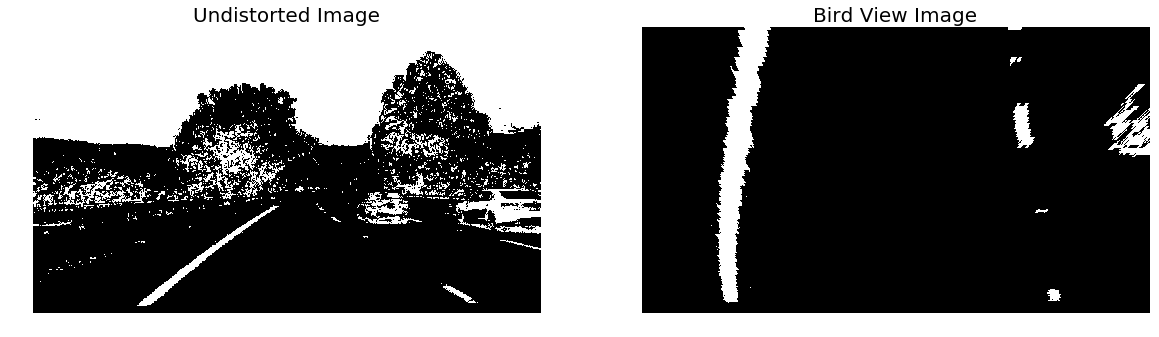

In [7]:
#calculate perspectiveTransform
def calculatePerspectiveTransform():
    # this data is optimize for 'test_images/test1.jpg'
    src_corner = [
        [580,460], # top left
        [280,680], # bottom left
        [740,460], # top right
        [1050,680]  # bottom right
    ]

    src = np.float32(src_corner)
    dst = np.float32([[200,0], [200,680], [1000,0], [1000,680]])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    return M

M = calculatePerspectiveTransform()

def getPerspectiveTransform(img):
    img_h = img.shape[0]
    img_w = img.shape[1]
    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, (img_w, img_h), flags=cv2.INTER_NEAREST)
    return img_as_ubyte(warped), M

#calculate perspective on test image
img_warped, M = getPerspectiveTransform(img_binary)

displayImagesForComparison(img_binary, img_warped, 'Undistorted Image', 'Bird View Image', is_gray=True)

### Apply Region Mask

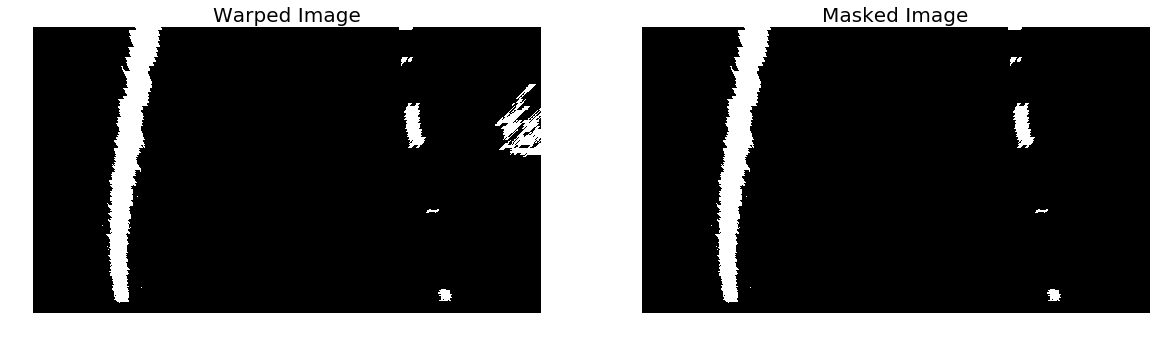

In [8]:
# Mask the required region to further fitler out the focused area
def applyMasking(img, vertices):
    mask = np.zeros_like(img)   
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        fill_color = (255,) * channel_count
    else:
        fill_color = 255

    # droping un-masked region
    cv2.fillPoly(mask, vertices, fill_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

vertices = np.array([[(120, 710),(200, 0), (1100, 0), (1150,710)]], dtype=np.int32)
masked_binary = applyMasking(img_warped, vertices)

displayImagesForComparison(img_warped, masked_binary, 'Warped Image', 'Masked Image', is_gray=True)

### Find lane pixels and fit to find the lane boundary

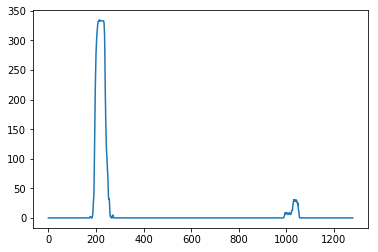

In [9]:
# Visualize using histogram to find pixel values for lane lines

def plot_hist(img, axis = 0):
    histogram = np.sum(img[int(img.shape[0]/2):,:], axis=0)
    plt.plot(histogram)
    return histogram

img_binary = masked_binary

histogram = plot_hist(img_binary)

(720, 0)

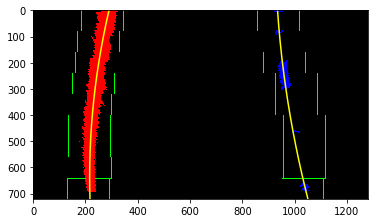

In [10]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def findlines(image, nwindows = 9, margin=80, minpix=50):
    """
    Find polynomial representation of the lines in the `image` using:
    - `nwindows` as the number of windows.
    - `margin` as the windows margin.
    - `minpix` as minimum number of pixes found to recenter the window.
    """    
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(image[int(image.shape[0]/2):,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img_binary, img_binary, img_binary))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    
    # Set height of windows
    window_height = np.int(image.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []


    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = image.shape[0] - (window+1)*window_height
        win_y_high = image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ### plot the figures
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
        
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculate the new radius of curvature
    left_curverad =  ((1 + (2*left_fit_cr[0] *y_eval*ym_per_pix + left_fit_cr[1])**2) **1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # Compute car position
    m_car = image.shape[1] / 2
    m_lane = (left_fitx[-1] + right_fitx[-1]) / 2
    offset_right_from_center_m = (m_lane-m_car)*xm_per_pix
    
    # Now our radius of curvature is in meters
    avg_radius_meters = np.mean([left_curverad, right_curverad])
    return out_img, avg_radius_meters, offset_right_from_center_m, left_fitx, right_fitx, ploty
    
img_lines, r_meters, right_from_center_m, l_fit, r_fit, ploty = findlines(img_binary)

# Visualization
plt.imshow(img_lines)
plt.plot(l_fit, ploty, color='yellow')
plt.plot(r_fit, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### Warp the detected lane boundaries back onto the original image

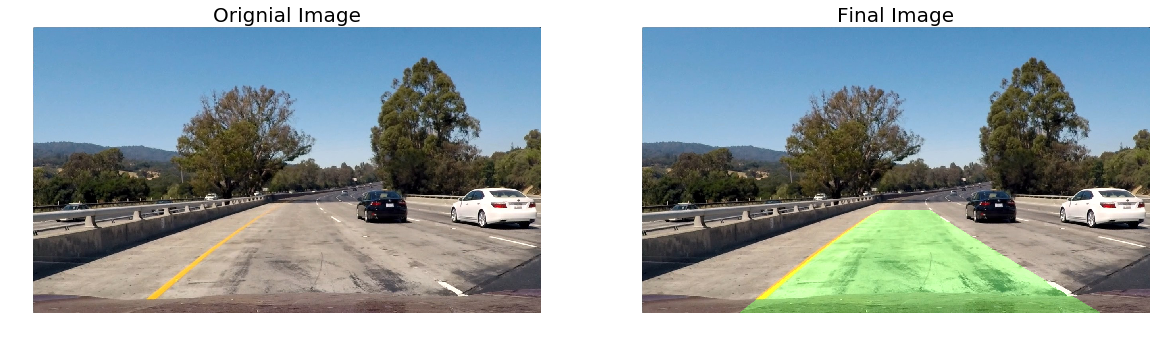

In [11]:
def drawLine(image, warped, Minv, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    color_warp = np.zeros_like(warped).astype(np.uint8)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))

    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    return result

# calculate inverse perspective matrix (Minv)
Minv = np.linalg.inv(M)

final_output = drawLine(img, img_lines, Minv, l_fit, r_fit, ploty)

displayImagesForComparison(img, final_output, 'Orignial Image', 'Final Image')

### Create video pipeline

In [12]:
def pipeline(input_image):
    img_undist = apply_undistort(input_image, mtx, dist)
    warped, M = getPerspectiveTransform(img_undist)
    binary = getTransformedImage(warped, sobel_kernel=9)
    
    #transformed = getTransformedImage(img_undist, sobel_kernel=9)
    #binary, M = getPerspectiveTransform(transformed)
    
    vertices = np.array([[(120, 710),(120, 0), (1150, 0), (1200,710)]], dtype=np.int32)
    masked_binary = applyMasking(binary, vertices)
       
    img_lines, r_meters, right_from_center_m, l_fit, r_fit, ploty = findlines(masked_binary)
    
    # Smooth out the result for 
    global l_fit_buffer
    global r_fit_buffer
    global prev_img_lines
    
    if prev_img_lines is None:
        prev_img_lines = binary

    # check for similarity in image
    match = cv2.matchShapes(prev_img_lines, binary, 1, 0.0)
    
    filter_size = 20
    
    # If matching upate the buffer
    if match < 50:
        prev_img_lines = binary

        if l_fit_buffer is None:
            l_fit_buffer = np.array([l_fit])

        if r_fit_buffer is None:
            r_fit_buffer = np.array([r_fit])

        l_fit_buffer = np.append(l_fit_buffer, [l_fit], axis=0)[-filter_size:]
        r_fit_buffer = np.append(r_fit_buffer, [r_fit], axis=0)[-filter_size:]
    
    # Compute the mean
    l_fit_mean = np.mean(l_fit_buffer, axis=0)
    r_fit_mean = np.mean(r_fit_buffer, axis=0)
    
    Minv = np.linalg.inv(M)
    lined = drawLine(input_image, img_lines, Minv, l_fit_mean, r_fit_mean, ploty)
    
    # Annotate text to show drive status
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "Radius of Crvature of the Lane: {:.0f} m".format(r_meters)
    cv2.putText(lined, text, (50,50), font, 1, (255,255,255), 2)
    text = "Vehicle Position: Offset Right from Center with {:.2f} m".format(right_from_center_m)
    cv2.putText(lined, text, (50,100), font, 1, (255,255,255), 2)

    annotated = np.array(lined)
    return annotated

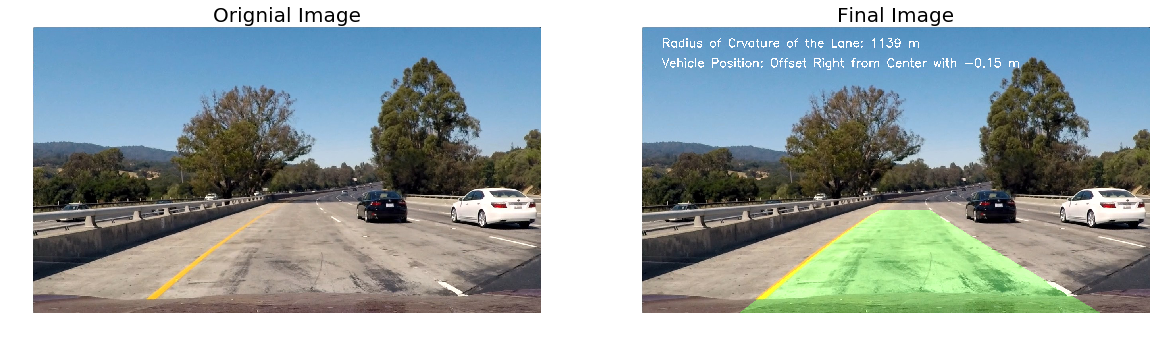

In [13]:
prev_img_lines = None
l_fit_buffer = None
r_fit_buffer = None

def resetGlobalBuffer():
    global l_fit_buffer
    global r_fit_buffer
    global prev_img_lines
    
    prev_img_lines = None
    l_fit_buffer = None
    r_fit_buffer = None

composit_out = pipeline(img)
displayImagesForComparison(img, composit_out, 'Orignial Image', 'Final Image')
resetGlobalBuffer()

### Generate video

In [14]:
def GenerateVideo(video_in, video_out):
    video = VideoFileClip(video_in)
    clip = video.fl_image(pipeline)
    %time clip.write_videofile(video_out, audio=False)
    resetGlobalBuffer()

In [15]:
# Create project video
GenerateVideo("./project_video.mp4", "./output_video/project_video_output.mp4")

[MoviePy] >>>> Building video ./output_video/project_video_output.mp4
[MoviePy] Writing video ./output_video/project_video_output.mp4


100%|█████████▉| 1260/1261 [03:50<00:00,  5.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_video/project_video_output.mp4 

Wall time: 3min 51s


In [16]:
# Create challange video
GenerateVideo("./challenge_video.mp4", "./output_video/challenge_video_output.mp4")

[MoviePy] >>>> Building video ./output_video/challenge_video_output.mp4
[MoviePy] Writing video ./output_video/challenge_video_output.mp4


100%|██████████| 485/485 [01:33<00:00,  5.63it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_video/challenge_video_output.mp4 

Wall time: 1min 33s
